#### Imports

In [303]:
import os 
import pandas as pd 
import numpy as np
import random as rd 
from faker import Faker
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm 

## Classes

In [351]:
class Cust: 
    def __init__(self,trans_prob:pd.DataFrame): 
        self.locations = trans_prob.keys()
        self.visited_locations = []
        self.timestamps = []
        self.trans_prob = trans_prob
        self.time_customer = self.get_entry_time()
         
        self.location = self.set_beginning_location()
        self.name = self.generate_name()
        

    
    def __repr__(self): 
        return f"{self.name} is currently @ {self.location}. Time: {self.time_customer}"


    def get_entry_time(self):
            probab = pd.read_csv("event_probab.csv")
            probab.set_index("timestamp",inplace=True)
            probab_ser = probab["probab"]
            timestamp = pd.to_datetime(rd.choices(probab_ser.index,probab_ser)[0])
            random_minute = rd.randint(0,30)
            timestamp = timestamp + pd.Timedelta(minutes=random_minute)
            timestamp_HM = timestamp.strftime("%H:%M")
            timestamp = pd.to_datetime(timestamp_HM) #assumes that the day of the simulation today (default value)
            self.timestamps.append(timestamp)
            return timestamp
                    

    
    def next_state(self):
        next_location = rd.choices(self.locations,weights=trans_prob[trans_prob.index == self.location].values[0])[0]
        self.visited_locations.append(next_location)
        self.location = next_location
        #Update time
        data = np.arange(1,15,0.1)
        pdf = norm.pdf(data , loc = 3, scale = 1 ) #assume that on average a customer takes 3 minutes to get to the next location
        timestep = rd.choices(data,pdf)[0]
        timestamp = self.time_customer + pd.Timedelta(minutes=timestep)
        self.timestamps.append(timestamp)
        self.time_customer = self.time_customer + pd.Timedelta(minutes=timestep)
    
    
    def generate_name(self): 
        f = Faker()
        return f.name()
      
    
    def set_beginning_location(self): 
        beginning_location = rd.choices(["fruit","dairy","spices","drinks"],weights=[0.393662,0.292958,0.159155,0.154225])[0] 
        self.visited_locations.append(beginning_location)
        return beginning_location
    
    
    def simulate_customer(self,verbose=True):
        if verbose: 
            print(f"Customer {self.name} went from Entrance to {self.location}. Time: {self.time_customer}")
        while self.location != "checkout":
            self.next_state()
            if verbose: 
                print(self)
        print("\nCustomer reached checkout")

            
            

In [384]:
class Supermarket:
    """Used to simulate today in the supermarket"""
    def __init__(self,name_supermarket:str,number_simulated_cust:int, trans_prob:pd.DataFrame): 
        self.name = name_supermarket
        self.opening_hours = pd.date_range(start="7:00", end="22:00", freq="1min")       
        self.sim_count = number_simulated_cust
        self.trans_prob = trans_prob
        
        self.customers = self.populate_supermarket()
        
    def populate_supermarket(self):
        customers = []
        for i in range(0,self.sim_count): 
            customers.append(Cust(self.trans_prob))
        return customers
    
    def simulate(self,create_df=False):            
        customers_df = []
        for customer in self.customers: 
            customer.simulate_customer()
            if create_df:
                customers_df.append(self.create_customer_df(customer))     
        if create_df:
            return self.create_full_df(customers_df)
                 

    def create_customer_df(self, customer:Cust):
        #name_column = customer.name * len(customer.visited_locations)
        timestamps = []
        for timestamp in customer.timestamps:
            #It could be the case that a customer spwawns (e.g) at 21:59 so that his timestamps go way above 22:00 
            #therefore we set those timestamps with hour == 22 simply to 22:00
            if timestamp.hour == 22:
                timestamps.append(pd.Timestamp("22:00"))
            else: 
                timestamps.append(timestamp) 
        return pd.DataFrame({"location":customer.visited_locations,"name": customer.name}, index=timestamps)
    
    def create_full_df(self,dfs:list):
        df_concat = pd.concat(dfs)
        df_concat.sort_index(inplace=True)
        return df_concat
        
            
        
    def simulate_verbose(self):
        pass
        
    
    
    

    

# Project 8: Markov Chains (Supermarkt Simulation) 

**Goal**: Write a program that simulates customer behaviour in a supermarket using a Markov Chain Simulation 

## Loading and cleaning the data 

### The Checkout Imputer 

I realized that I am using the get_group() function probably in a way that was not intended by the pandas developers 

I should have just **sorted** by the customer_no, I realized this too late, thus I'll run with this solution!

In [27]:
def create_checkout_rows(df,verbose=False): 
    if verbose: 
        print(f"Length of Dataframe before imputing: {len(df)}\n")
    
    
    customers = df["customer_no"].unique() 
    customer_groups = df.groupby("customer_no")[["location","customer_no"]]
    
    for customer in customers: 
        customer_id = customer_groups.get_group(customer)["customer_no"].unique()[0]
        visited_locations = list(customer_groups.get_group(customer)["location"])
        
        if "checkout" not in visited_locations: 
            if verbose:
                print(f"There is no checkout for visitor: {customer_id}") 
                print("Adding a checkout row to the df ...\n" )
            timestamp = customer_groups.get_group(customer).index[-1] + pd.Timedelta(minutes=5) #Adding 5 Minutes for the checkout

            df_checkout = pd.DataFrame({"customer_no":customer_id,"location":"checkout"},index=[timestamp])
            df = pd.concat([df,df_checkout]) 

    if verbose:
        print(f"Length of Dataframe after imputing:{len(df)}") 
    return df 

        

### The problem of the customer ids 

There is a problem with the given dataset: The column "customer_no" does not specifiy unique customers, we can solve this problem simply by grouping customer_no and the day 

### Load the different csv files and concatenate the different dataframes 

In [28]:
csv_files = os.listdir("../Data/") 
csv_files

['tuesday.csv', 'thursday.csv', 'friday.csv', 'wednesday.csv', 'monday.csv']

In [29]:
dfs = []
for file in csv_files: 
    df = pd.read_csv(f"../Data/{file}", sep=";", parse_dates=["timestamp"],index_col="timestamp")
    df = create_checkout_rows(df) 
    dfs.append(df)

df_total = pd.concat(dfs)
df_total.sort_index(inplace=True)

In [30]:
len(df_total)

24905

In [31]:
df_total

,customer_no,location
2019-09-02 07:03:00,2,dairy
2019-09-02 07:03:00,1,dairy
2019-09-02 07:04:00,8,fruit
2019-09-02 07:04:00,7,spices
2019-09-02 07:04:00,3,dairy
...,...,...
2019-09-06 21:54:00,1505,checkout
2019-09-06 21:55:00,1510,checkout
2019-09-06 21:55:00,1496,checkout
2019-09-06 21:55:00,1500,checkout


## Calculate the transition probabilities 

In [32]:
df_total.rename(columns={"location": "before"},inplace=True)

In [33]:
df_probab = pd.DataFrame({"before":df_total["before"],"customer":df_total["customer_no"]})

In [34]:
df_probab.head()

,before,customer
2019-09-02 07:03:00,dairy,2
2019-09-02 07:03:00,dairy,1
2019-09-02 07:04:00,fruit,8
2019-09-02 07:04:00,spices,7
2019-09-02 07:04:00,dairy,3


#### Trying one simple example!

In [35]:
filt = df_probab["customer"]==1
df_probab_one = df_probab[filt]

In [36]:
df_probab_one["after"] = df_probab_one["before"].shift(-1) 

/tmp/ipykernel_270212/2853813503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_probab_one["after"] = df_probab_one["before"].shift(-1)


In [37]:
groups = df_probab_one.groupby(df_probab_one.index.day)[["before"]]

In [38]:
df_x = groups.get_group(3).head()

In [39]:
df_x["after"] = df_x["before"].shift(-1) 

In [40]:
df_x.fillna("checkout") 

,before,after
2019-09-03 07:02:00,fruit,drinks
2019-09-03 07:05:00,drinks,checkout
2019-09-03 07:12:00,checkout,checkout


#### Now generalize!

In [41]:
df_probab.head()

,before,customer
2019-09-02 07:03:00,dairy,2
2019-09-02 07:03:00,dairy,1
2019-09-02 07:04:00,fruit,8
2019-09-02 07:04:00,spices,7
2019-09-02 07:04:00,dairy,3


In [42]:
df_probab["after"] = df_probab.groupby([df_probab.index.day,df_probab.customer]).transform(
                                                    lambda x: x.shift(-1).fillna("checkout"))

In [43]:
df_probab.groupby([df_probab.index.day,df_probab.customer]).get_group((3,21)) #Having a look! :) 


,before,customer,after
2019-09-03 07:14:00,drinks,21,spices
2019-09-03 07:15:00,spices,21,drinks
2019-09-03 07:17:00,drinks,21,checkout
2019-09-03 07:20:00,checkout,21,checkout


In [44]:
df_probab.drop("customer",axis=1,inplace=True)

In [45]:
df_probab.reset_index(drop=True)

,before,after
0,dairy,checkout
1,dairy,checkout
2,fruit,checkout
3,spices,drinks
4,dairy,checkout
...,...,...
24900,checkout,checkout
24901,checkout,checkout
24902,checkout,checkout
24903,checkout,checkout


### Create the transition probabilities matrix

In [46]:
df_crosstab = pd.crosstab(df_probab['before'], df_probab['after'], normalize=0)
df_crosstab

after,checkout,dairy,drinks,fruit,spices
before,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.393033,0.000000,0.222483,0.189357,0.195127
drinks,0.537260,0.027145,0.000000,0.218950,0.216645
fruit,0.500195,0.237993,0.136080,0.000000,0.125732
spices,0.251998,0.323122,0.272776,0.152104,0.000000


In [100]:
trans_prob = pd.crosstab(df_probab['before'], df_probab['after'], normalize=0)

## Simulate 

### Simulation for one customer 

#### Inspecting some attributes

In [317]:
c1 = Cust(trans_prob)


In [318]:
c1.name

'Frank Ramirez'

In [265]:
c1.location

'fruit'

In [266]:
c1.visited_locations

['fruit']

In [267]:
c1.locations 

Index(['checkout', 'dairy', 'drinks', 'fruit', 'spices'], dtype='object', name='after')

In [268]:
c1.churned

False

#### Creating a simulation for one customer 

In [327]:
c2 = Cust(trans_prob)

In [328]:
c2.location

'fruit'

In [329]:
c2.simulate_customer()

Customer Jennifer Stone went from Entrance to fruit
Jennifer Stone is currently @ checkout. Time: 2022-07-10 17:25:18

Customer reached checkout


In [330]:
c2.visited_locations

['fruit', 'checkout']

### Creating a simulation for multiple customers 

In [385]:
supermarket = Supermarket("Michaels Aldi",500,trans_prob)

In [386]:
df_sim = supermarket.simulate(create_df=True)

Customer Brian Petersen went from Entrance to dairy. Time: 2022-07-10 07:35:00
Brian Petersen is currently @ spices. Time: 2022-07-10 07:39:42
Brian Petersen is currently @ checkout. Time: 2022-07-10 07:43:48

Customer reached checkout
Customer Justin Mooney went from Entrance to spices. Time: 2022-07-10 08:12:00
Justin Mooney is currently @ fruit. Time: 2022-07-10 08:13:30
Justin Mooney is currently @ checkout. Time: 2022-07-10 08:14:36

Customer reached checkout
Customer Henry Jones went from Entrance to dairy. Time: 2022-07-10 14:47:00
Henry Jones is currently @ drinks. Time: 2022-07-10 14:49:54
Henry Jones is currently @ checkout. Time: 2022-07-10 14:52:30

Customer reached checkout
Customer Debbie Evans went from Entrance to drinks. Time: 2022-07-10 08:45:00
Debbie Evans is currently @ spices. Time: 2022-07-10 08:47:54
Debbie Evans is currently @ dairy. Time: 2022-07-10 08:51:24
Debbie Evans is currently @ drinks. Time: 2022-07-10 08:55:36
Debbie Evans is currently @ checkout. Tim

In [387]:
len(df_sim)

1682

In [389]:
df_sim.head()

,location,name
2022-07-10 07:01:00,fruit,Stacey Brown MD
2022-07-10 07:03:00,dairy,Earl Whitaker
2022-07-10 07:04:18,checkout,Stacey Brown MD
2022-07-10 07:06:24,spices,Earl Whitaker
2022-07-10 07:07:54,checkout,Earl Whitaker


In [394]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1682 entries, 2022-07-10 07:01:00 to 2022-07-10 22:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  1682 non-null   object
 1   name      1682 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


In [403]:
df_sim.groupby("name").get_group("Anna Murphy")

,location,name
2022-07-10 22:00:00,checkout,Anna Murphy
2022-07-10 22:00:00,fruit,Anna Murphy


In [450]:
df_sim["time"] = df_sim.index
df_sim.reset_index(inplace=True,drop=True)

In [454]:
df_sim.head()

,location,name,time
0,fruit,Stacey Brown MD,2022-07-10 07:01:00
1,dairy,Earl Whitaker,2022-07-10 07:03:00
2,checkout,Stacey Brown MD,2022-07-10 07:04:18
3,spices,Earl Whitaker,2022-07-10 07:06:24
4,checkout,Earl Whitaker,2022-07-10 07:07:54


In [455]:
df_sim.to_csv("simulation.csv",index=False)

## Load simulation csv and explore a bit! 

In [459]:
df = pd.read_csv("simulation.csv",parse_dates=["time"])
df.head()

,location,name,time
0,fruit,Stacey Brown MD,2022-07-10 07:01:00
1,dairy,Earl Whitaker,2022-07-10 07:03:00
2,checkout,Stacey Brown MD,2022-07-10 07:04:18
3,spices,Earl Whitaker,2022-07-10 07:06:24
4,checkout,Earl Whitaker,2022-07-10 07:07:54


In [460]:
df.set_index("time",inplace=True)

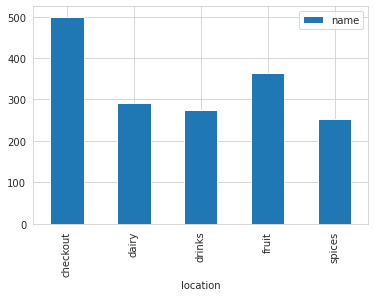

In [464]:
df.groupby("location").count().plot(kind="bar");

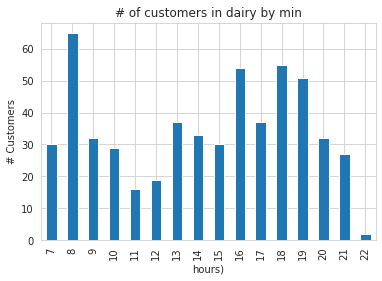

In [472]:
ax = df.resample("h")["name"].nunique().plot(title="# of customers in dairy by min",
                                                  kind="bar",
                                                  xlabel="hours)", ylabel="# Customers");
ax.set_xticklabels(set(df.index.hour));